# Deriving the PDF of OMC-2

In [30]:
%matplotlib inline

Import packages

In [31]:
from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib
from astropy import units as u
import aplpy

Show the region to statistic (N>1.5e22)

INFO: Auto-setting vmin to -9.311e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.506e+23 [aplpy.core]
INFO: Auto-setting vmin to  3.901e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.360e+23 [aplpy.core]


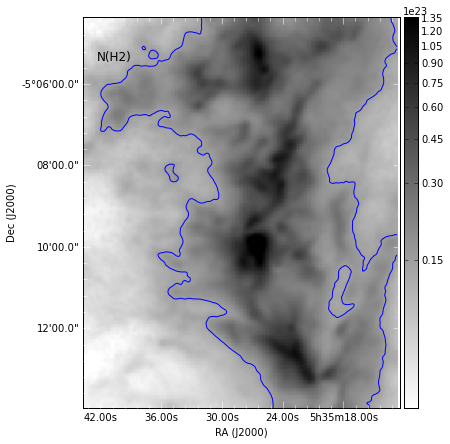

In [32]:
mpl.rc("xtick", direction='in')
mpl.rc("ytick", direction='in')
#define input and output file name, and import N_H2 map
N_file='/Users/shjiao/documents/orion/sedlarge/sedlast/nh2.omc2.fits'
fig_file_omc2='PDF_omc2.png'
f_omc2 = aplpy.FITSFigure('/Users/shjiao/documents/orion/sedlarge/sedlast/nh2.omc2.fits', figsize=(7,7))
#f_omc2.colorbar.set_axis_label_text('N(H2)(cm-2)')
f_omc2.add_label(0.1,0.9, 'N(H2)', color='black', relative=True, size='large',layer='source')
f_omc2.show_grayscale()
f_omc2.add_colorbar()
f_omc2.colorbar.show()

f_omc2.recenter(83.867,-5.1526276,width=0.13,height=0.16)
f_omc2.show_contour('/Users/shjiao/documents/orion/sedlarge/sedlast/nh2.omc2.fits',levels=[1.5e22],colors='blue',width='2')
f_omc2.show_colorscale(cmap='gist_yarg',stretch='log')

hdu=fits.open(N_file)
data = hdu[0].data

Statistic the data from this region

In [33]:
for i in range(0,data.shape[0]):
  for j in range(0,data.shape[1]):
       if np.isnan(data[i][j]):
           data[i][j]=0.

data=data[data==data].flatten()
#statistic the data
mean=data.mean()
eta_array=np.log(data/mean) #eta = ln(N/N_mean)
print('Mean:',mean,'\n')
print data

('Mean:', 2.2045536910355661e+22, '\n')
[  3.94403246e+21   4.01037604e+21   4.06139030e+21 ...,   1.35689000e+22
   1.32988000e+22   1.29818597e+22]


In [34]:
#define normal , double peak normal and linear function
def normal(eta,p0,sig0,eta0) :
    return p0 / np.sqrt(2*np.pi*sig0**2) *np.exp( -(eta-eta0)**2 /(2*sig0**2) )

def double_peak(eta,p0,p1,sig0,sig1,eta0,eta1) :
    return ( p0 / np.sqrt(2*np.pi*sig0**2) *np.exp(-(eta-eta0)**2 /(2*sig0**2)) + p1 / np.sqrt(2*np.pi*sig1**2) *np.exp(-(eta-eta1)**2 /(2*sig1**2)) )

def linear(eta,m,b) :
    return m*eta+b

('p:', 0.9606948173986074)
('sigma:', 0.66976172910355991)
('eta', -0.26048226501330074, '\n')
('m:', -3.0138932841610457)


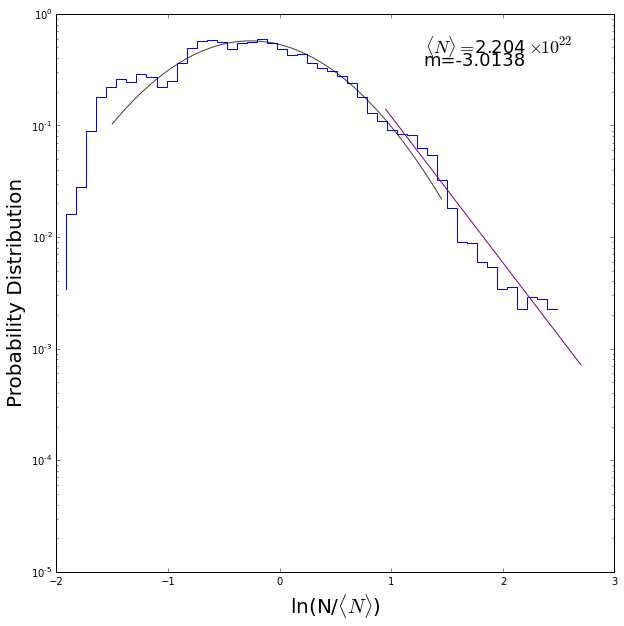

In [44]:
prob_den,bins=np.histogram(eta_array,bins=50,density=True)
bin_value=0.5*(bins[1:]+bins[:-1])

#plot the PDF
plt.figure(figsize=(10,10))
plt.plot(bin_value,prob_den,linestyle='steps-',color='blue')
plt.ylabel('Probability Distribution',size=20)
plt.xlabel(r'ln(N/$\langle N \rangle$)',size=20)
plt.yscale('log')
plt.ylim(0.00001,1)
text_mean=str(mean)
text_mean=r'$\langle N \rangle=$'+text_mean[:5]+r'$\times 10^{22}$'
plt.text(1.3,0.45,text_mean,size=18)

#define the range to fit
fit_lower=-1.
fit_upper=1.
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[prob_den[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]

#fit the one peak
x=np.arange(fit_lower-0.5,fit_upper+0.5,0.05)
popt,pcov=curve_fit(normal,xdata,ydata,p0=[0.5,1,0])
print('p:',popt[0])
print('sigma:',popt[1])
print('eta',popt[2],'\n')

#plot the one peak curve
plt.plot(x,normal(x,popt[0],popt[1],popt[2]),color='black',alpha=0.75)

#fit the power tail
fit_lower=1.
fit_upper=2.7
xdata=[bin_value[i] for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
ydata=[np.log(prob_den[i]) for i in range(len(bin_value)) if (bin_value[i]>=fit_lower) and (bin_value[i]<=fit_upper)]
popt,pcov=curve_fit(linear,xdata,ydata,p0=[-1,1])
print('m:',popt[0])

#plot the power tail
x=np.arange(fit_lower-0.05,fit_upper+0.05,0.05)
y=np.exp(linear(x,popt[0],popt[1]))
plt.plot(x,y,'-',color='purple')
text_m=str(popt[0])[:7]
text_m='m='+text_m
plt.text(1.3,0.35,text_m,size=18)

plt.show()